In [8]:
!gdown 1moSx_asOv-DIr6QcstQl1moFm_DyyU-Q

!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/

!kaggle datasets download -d mansourehk/shemo-persian-speech-emotion-detection-database


Downloading...
From: https://drive.google.com/uc?id=1moSx_asOv-DIr6QcstQl1moFm_DyyU-Q
To: /content/kaggle.json
100% 67.0/67.0 [00:00<00:00, 216kB/s]
 99% 820M/829M [00:08<00:00, 203MB/s]
100% 829M/829M [00:08<00:00, 108MB/s]


In [42]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import zipfile


# Extract the contents of the ZIP file
with zipfile.ZipFile('/content/shemo-persian-speech-emotion-detection-database.zip', 'r') as zip_ref:
    zip_ref.extractall("/content/data")  # Change the path as needed

SHEMO_directory_list = os.listdir("/content/data")

file_emotion = []
file_path = []
m_f_t=[]
for dir in ['male', 'female']:
    actor = os.listdir("/content/data/" + dir)
    for file in actor:
        part = file.split('.')[0]
        m_f_t.append(str(part[0])+'L')
        file_emotion.append(str(part[3]))  # Emotion label
        file_path.append("/content/data/" + dir + '/' + file)  # File path

# Creating dataframes for emotions and file paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
m_f_t_df = pd.DataFrame(m_f_t,columns=['Speaker'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ShEMO_df = pd.concat([m_f_t_df, emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
ShEMO_df.head()

,Speaker,Emotions,Path
0,ML,N,/content/data/male/M12N86.wav
1,ML,A,/content/data/male/M26A21.wav
2,ML,N,/content/data/male/M12N35.wav
3,ML,A,/content/data/male/M28A10.wav
4,ML,A,/content/data/male/M53A20.wav


In [27]:
pd.value_counts(ShEMO_df['Speaker'])

ML    1737
FL    1263
Name: Speaker, dtype: int64

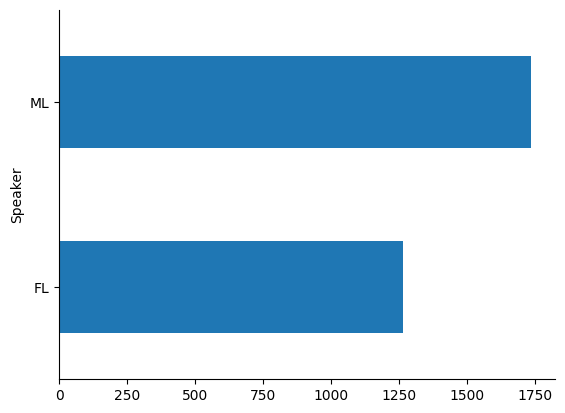

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
ShEMO_df.groupby('Speaker').size().plot(kind='barh')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [29]:
pd.value_counts(ShEMO_df['Emotions'])

A    1059
N    1028
S     449
W     225
H     201
F      38
Name: Emotions, dtype: int64

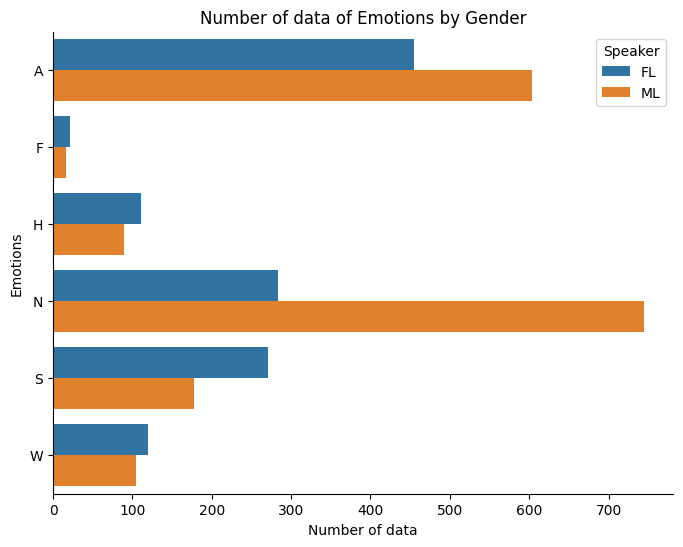

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns
grouped = ShEMO_df.groupby(['Speaker', 'Emotions']).size().reset_index(name='count')

# Plotting the grouped bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='Emotions', hue='Speaker', data=grouped)

# Removing the spines (top and right)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding labels and title
plt.xlabel('Number of data')
plt.ylabel('Emotions')
plt.title('Number of data of Emotions by Gender')

plt.show()


In [43]:
emotion_mapping = {'S': 0, 'A': 1, 'H': 2, 'W': 3, 'F': 4, 'N': 5}

# Assuming `dataframe` is your DataFrame
ShEMO_df['labels'] = ShEMO_df['Emotions'].map(emotion_mapping)

In [44]:
import librosa
def get_time_duration(path):
    audio, sr = librosa.load(path)
    duration_sec = librosa.get_duration(y=audio, sr=sr)
    return duration_sec

ShEMO_df['time'] = ShEMO_df['Path'].apply(get_time_duration)

In [45]:
ShEMO_df

,Speaker,Emotions,Path,labels,time
0,ML,N,/content/data/male/M12N86.wav,5,1.463447
1,ML,A,/content/data/male/M26A21.wav,1,1.689660
2,ML,N,/content/data/male/M12N35.wav,5,4.497460
3,ML,A,/content/data/male/M28A10.wav,1,6.982358
4,ML,A,/content/data/male/M53A20.wav,1,2.720499
...,...,...,...,...,...
2995,FL,H,/content/data/female/F30H01.wav,2,3.772880
2996,FL,A,/content/data/female/F17A03.wav,1,1.902268
2997,FL,N,/content/data/female/F29N06.wav,5,2.654104
2998,FL,S,/content/data/female/F09S11.wav,0,3.484444


In [46]:
ShEMO_df.describe(include="all")

,Speaker,Emotions,Path,labels,time
count,3000,3000,3000,3000.000000,3000.000000
unique,2,6,3000,NaN,NaN
top,ML,A,/content/data/male/M12N86.wav,NaN,NaN
freq,1737,1059,1,NaN,NaN
mean,NaN,NaN,NaN,2.476000,4.111807
std,NaN,NaN,NaN,1.983953,3.414900
min,NaN,NaN,NaN,0.000000,0.358639
25%,NaN,NaN,NaN,1.000000,1.955113
50%,NaN,NaN,NaN,1.000000,3.079637
75%,NaN,NaN,NaN,5.000000,5.104093


# Balancing

In [38]:
!pip install datasets
!pip install -U imbalanced-learn
!pip install pydub

In [47]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

resampling_pipeline = Pipeline([
    ('over_sampler', over_sampler),
    ('under_sampler', under_sampler)
])

X_res, y_res = resampling_pipeline.fit_resample(ShEMO_df, ShEMO_df['labels'])

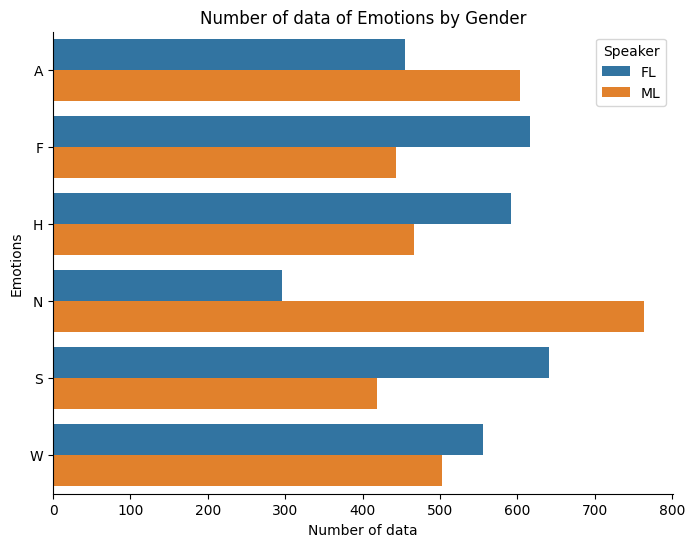

In [48]:
from matplotlib import pyplot as plt
import seaborn as sns
grouped = X_res.groupby(['Speaker', 'Emotions']).size().reset_index(name='count')

# Plotting the grouped bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='Emotions', hue='Speaker', data=grouped)

# Removing the spines (top and right)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding labels and title
plt.xlabel('Number of data')
plt.ylabel('Emotions')
plt.title('Number of data of Emotions by Gender')

plt.show()


# Preprocess

In [49]:
train_df, temp = train_test_split(ShEMO_df, test_size=0.2, stratify=ShEMO_df['labels'])
test_df, valid_df = train_test_split(temp, test_size=0.5, stratify=temp['labels'])

In [50]:
train_df["labels"].value_counts()

1    847
5    822
0    359
3    180
2    161
4     31
Name: labels, dtype: int64

In [51]:
test_df["labels"].value_counts()

1    106
5    103
0     45
3     23
2     20
4      3
Name: labels, dtype: int64

In [52]:
valid_df["labels"].value_counts()

1    106
5    103
0     45
3     22
2     20
4      4
Name: labels, dtype: int64

In [41]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["Path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)
valid_data = Dataset.from_pandas(valid_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('facebook/hubert-base-ls960')

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [42]:
def preprocess_function(examples):
    audio_arrays = [x for x in examples["speech"]]
    inputs = feature_extractor(audio_arrays,
                               sampling_rate=feature_extractor.sampling_rate,
                               truncation=True, padding=True, max_length=16000)
    return inputs


train_data = train_data.map(preprocess_function, batched=True).with_format("torch")
test_data = test_data.map(preprocess_function, batched=True).with_format("torch")
valid_data = valid_data.map(preprocess_function, batched=True).with_format("torch")


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

# fine tuning

In [53]:
import torch.nn as nn
from transformers import HubertModel

class AudioClassifierHubert(nn.Module):
    def __init__(self, calc_mean_on_nonzero=False):
        super(AudioClassifierHubert, self).__init__()
        self.hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
        self.hubert_model.feature_extractor._freeze_parameters()
        self.batch_norm = nn.BatchNorm1d(768)
        self.relu_activation = nn.ReLU(inplace=True)
        self.dropout_layer = nn.Dropout(0.4)
        self.output_layer = nn.Linear(768, 6)
        self.calc_mean_on_nonzero = calc_mean_on_nonzero

    def forward(self, input_tensor):
        input_tensor = input_tensor[:, 0]
        hubert_output = self.hubert_model(input_tensor)['last_hidden_state']
        del input_tensor
        if self.calc_mean_on_nonzero:
            processed_output = self.batch_norm(hubert_output.mean(axis=1))
        else:
            nonzero_output = hubert_output.sum(dim=1) / (hubert_output != 0).sum(dim=1)
            processed_output = self.batch_norm(nonzero_output)
        processed_output = self.relu_activation(processed_output)
        processed_output = self.dropout_layer(processed_output)
        final_output = self.output_layer(processed_output)
        final_output = self.relu_activation(final_output)

        return final_output


In [57]:
import torch
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioClassifierHubert().to(device)

optim = AdamW(model.parameters(), lr=1e-5)

def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_v', 'encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

In [ ]:
import time
from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 10

# Start training
model.train()

train_loss = list()
train_accuracies = list()

val_loss = list()
val_accuracies = list()

for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    correct = 0
    count = 0
    accuracy=0
    loss=0
    accuracy_valid=0
    average_valid_loss=0
    epoch_loss = list()

    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids)
        loss = nn.CrossEntropyLoss(outputs, labels)
        loss.backward()
        optim.step()

        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Train Loss': '{:.3f}'.format(loss.item()),
            'Train Accuracy': '{:.3f}'.format(accuracy)
        })

        # record the loss for each batch
        epoch_loss.append(loss.item())

    model.eval()
    correct_val = 0
    total_val = 0
    epoch_val_loss = 0.0

    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

    pbar_valid = tqdm(valid_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in pbar_valid:
            input_ids = batch['input_values'].to(device)
            labels = batch['labels'].to(device)

            labels_pred = model(input_ids)
            loss = nn.CrossEntropyLoss(labels_pred, labels)

            _, predicted = torch.max(labels_pred.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            epoch_val_loss += loss.item()

            accuracy_val = correct_val / total_val
            average_val_loss = epoch_val_loss / (pbar_valid.n + 1)
            pbar_valid.set_postfix(loss=average_val_loss, accuracy=accuracy_val)
            pbar_valid.update()

    val_accuracies.append(accuracy_valid)
    val_loss.append(average_valid_loss)
    pbar_valid.close()

    train_loss += epoch_loss
    train_accuracies.append(accuracy)
    pbar.close()

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlim(0, 10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlim(0, 10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_values'].to(device)
        labels = batch['labels'].type(torch.LongTensor).to(device)

        labels_pred = model(input_ids)
        _, predicted = torch.max(labels_pred.data, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

conf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

class_names = [f'Class {i}' for i in range(6)]
report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:\n', report)